# SKKU 2025 Quantum Challenge 
## Measuring Berry phase in quantum computing

Writer: Sangyoon Woo

In [1]:
import math
import cmath
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import warnings
from scipy.linalg import expm
from scipy.linalg import eigh

warnings.filterwarnings('ignore')

## Part 1

#### Question 1.3

In [2]:
# (0)
def h_vec_0(lmbd):
    return np.array([1, 0, 0])

# (1)
def h_vec_1(lmbd):
    return np.array([
        np.cos(2 * np.pi * lmbd),
        np.sin(2 * np.pi * lmbd),
        0
    ])

# (2)
def h_vec_2(lmbd):
    if lmbd < 1/3:
        t = 3 * lmbd
        return np.array([
            np.cos(np.pi/2 * t),
            np.sin(np.pi/2 * t),
            0
        ])
    elif lmbd < 2/3:
        t = 3 * lmbd - 1
        return np.array([
            0,
            np.cos(np.pi/2 * t),
            np.sin(np.pi/2 * t)
        ])
    else:
        t = 3 * lmbd - 2
        return np.array([
            np.sin(np.pi/2 * t),
            0,
            np.cos(np.pi/2 * t)
        ])

# (3)
def h_vec_3(lmbd):
    if lmbd < 0.5:
        t = 2 * lmbd
        return np.array([
            np.cos(np.pi * t),
            np.sin(np.pi * t),
            0
        ])
    else:
        t = 2 * lmbd - 1
        return np.array([
            -np.cos(np.pi * t),
            0,
            np.sin(np.pi * t)
        ])


In [3]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def plot_bloch_path(bloch_points):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    

    u, v = np.mgrid[0:2*np.pi:60j, 0:np.pi:30j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color='lightgray', alpha=0.15, linewidth=0)
    
    ax.plot(bloch_points[:, 0], bloch_points[:, 1], bloch_points[:, 2], 
            color='red', linewidth=2)
    
    start = bloch_points[0]

    ax.quiver(0, 0, 0, 1.2, 0, 0, color='k', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 1.2, 0, color='k', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 0, 1.2, color='k', arrow_length_ratio=0.1)
    ax.text(1.3, 0, 0, r'$\hat{n}_x$', fontsize=12)
    ax.text(0, 1.3, 0, r'$\hat{n}_y$', fontsize=12)
    ax.text(0, 0, 1.3, r'$\hat{n}_z$', fontsize=12)
    
    ax.view_init(elev=25, azim=45)
    ax.set_box_aspect([1, 1, 1])
    ax.set_title('Bloch Sphere Path (rotated view)')

    plt.show()

def simulate_berry_phase(h_vec, T=2*np.pi, Nt=1000, 
                         plot_overlap=True, bloch=True):
    
    dt = T / Nt
    E0 = -1.0 

    psi0 = np.array([1, -1]) / np.sqrt(2)
    
    psi = psi0.copy()
    

    time_steps = [0.0]
    overlaps_amp = [1.0]
    total_phases = [0.0]
    berry_phases = [0.0]
    dynamical_phases_acc = [0.0]
    bloch_points = [h_vec(0.0)]

    for n in range(Nt):
        t_current = (n + 1) * dt
        lmbd_for_H = n * dt / T  
        lmbd_current = t_current / T 

        h = h_vec(lmbd_for_H)
        H = h[0]*X + h[1]*Y + h[2]*Z
        U = expm(-1j * H * dt)
        psi = U @ psi  
        
        O = np.vdot(psi0, psi)
        
        current_total_phase = -np.angle(O)
        current_dyn_phase = E0 * t_current 
        current_berry_phase = current_total_phase - current_dyn_phase
        
        time_steps.append(t_current)
        overlaps_amp.append(np.abs(O))
        total_phases.append(current_total_phase)
        berry_phases.append(current_berry_phase)
        dynamical_phases_acc.append(current_dyn_phase)
        bloch_points.append(h_vec(lmbd_current))

    time_steps = np.array(time_steps)
    overlaps_amp = np.array(overlaps_amp)
    total_phases = np.array(total_phases)
    berry_phases = np.array(berry_phases)
    dynamical_phases_acc = np.array(dynamical_phases_acc)
    bloch_points = np.array(bloch_points)
    
    if plot_overlap:

        plt.figure(figsize=(6, 3))
        plt.plot(time_steps, overlaps_amp, color='royalblue', label='$|O(t)|$')
        plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, 
                    label='Initial state ($|O|=1$)')
        plt.title('$|O(t)|$ (Overlap Amplitude)')
        plt.xlabel('Time (t)')
        plt.ylabel('Amplitude')
        plt.legend(loc='lower right')
        plt.ylim(-0.1, 1.1) 
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(6, 3))

        plt.plot(time_steps, np.unwrap(total_phases), 
                 label=r'$\theta_{total}(t)$ (Total Phase)')
        plt.plot(time_steps, np.unwrap(berry_phases), 
                 label=r'$\theta_{Berry}(t)$ (Berry Phase)')
        plt.plot(time_steps, dynamical_phases_acc, 
                 label=r'Dynamical Phase ($\int E_0 dt$)', 
                 linestyle='--', color='gray')
        
        plt.title('Phase Evolution')
        plt.xlabel('Time (t)')
        plt.ylabel('Phase (rad)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    
    if bloch:
        plot_bloch_path(bloch_points)
    
    final_berry_phase = total_phases[-1] % (2 * np.pi)
    print(f'Final Berry phase (mod 2pi) = {final_berry_phase:.3f} rad')

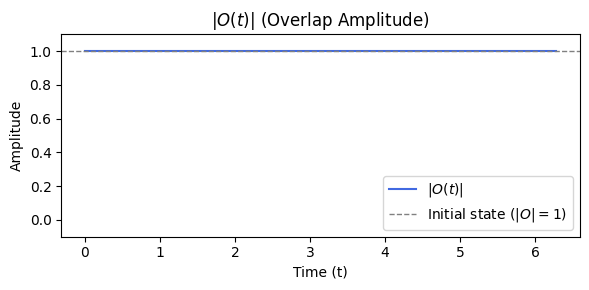

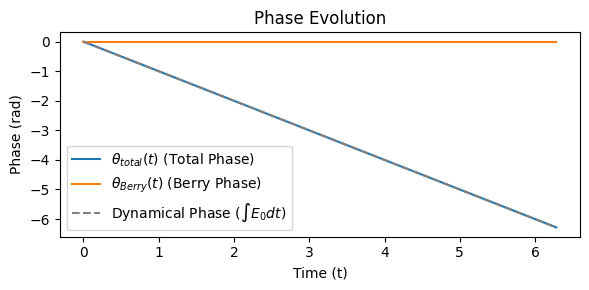

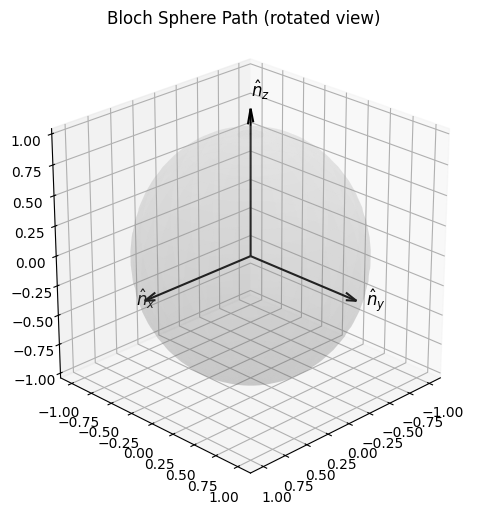

Final Berry phase (mod 2pi) = 6.283 rad


In [4]:
simulate_berry_phase(h_vec_0, T=2*np.pi)


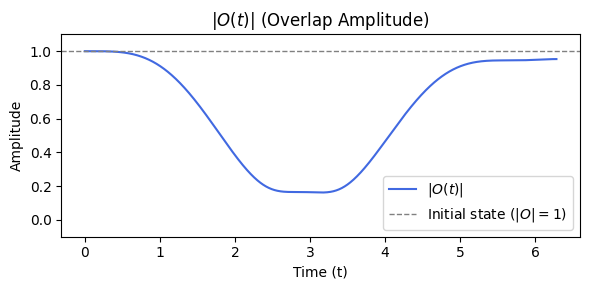

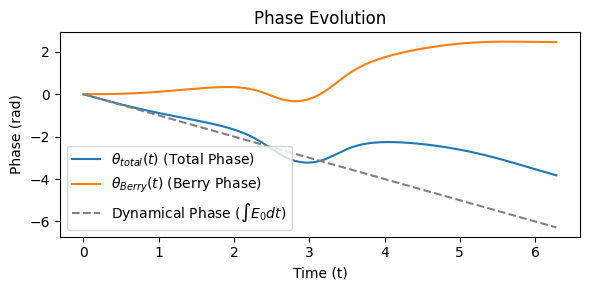

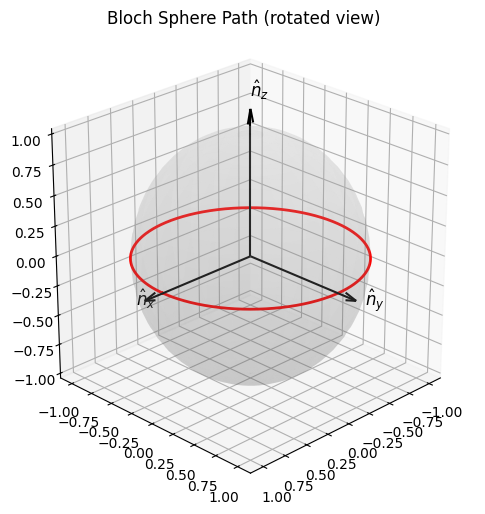

Final Berry phase (mod 2pi) = 2.455 rad


In [5]:
simulate_berry_phase(h_vec_1, T=2*np.pi)

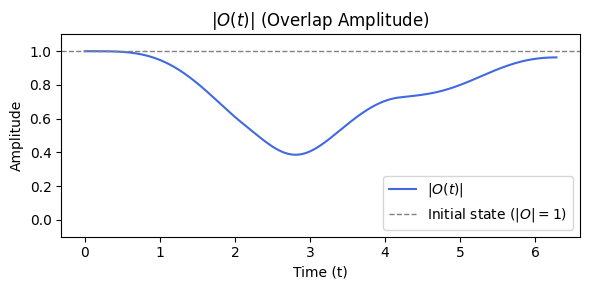

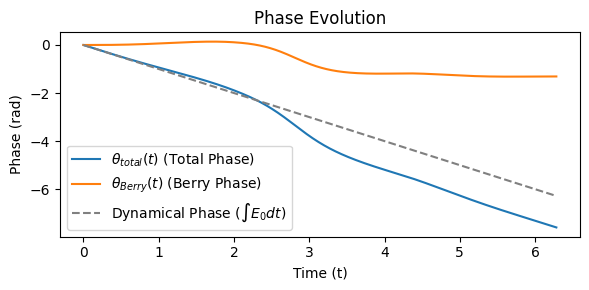

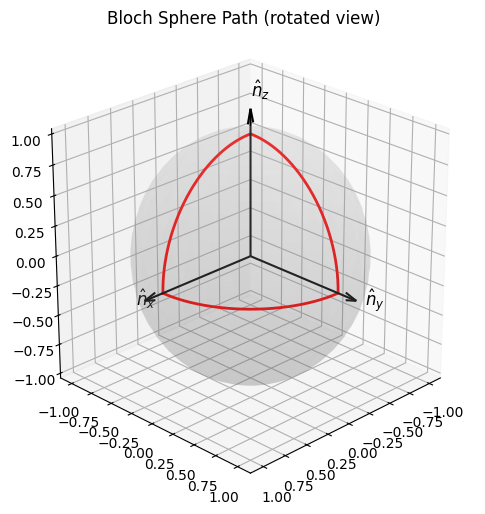

Final Berry phase (mod 2pi) = 4.974 rad


In [6]:
simulate_berry_phase(h_vec_2, T=2*np.pi)

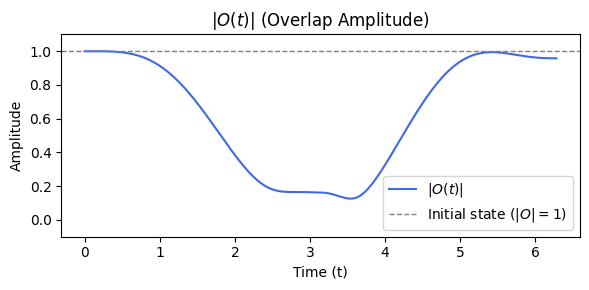

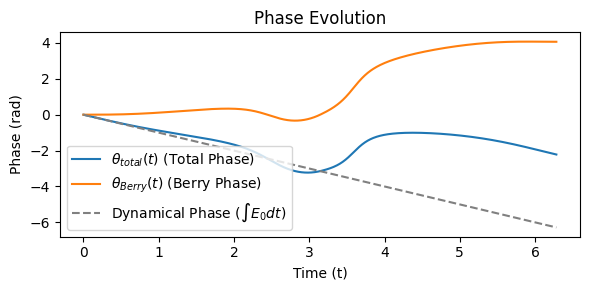

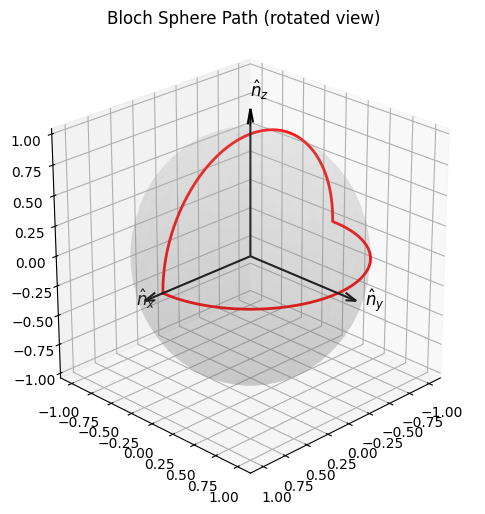

Final Berry phase (mod 2pi) = 4.065 rad


In [7]:
simulate_berry_phase(h_vec_3, T=2*np.pi)

## Part 2

#### Question 2.1

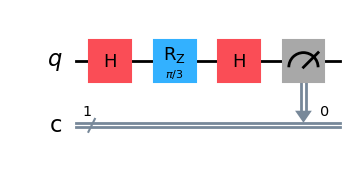

In [8]:
theta = np.pi / 3

qc = QuantumCircuit(1, 1)
qc.h(0)     
qc.rz(theta, 0)  
qc.h(0)   
qc.measure(0, 0)

qc.draw('mpl')

In [9]:
sim = AerSimulator()
result = sim.run(qc, shots=100000).result()
counts = result.get_counts()

print('Measurement counts:', counts)

Measurement counts: {'0': 74801, '1': 25199}


#### Question 2.2

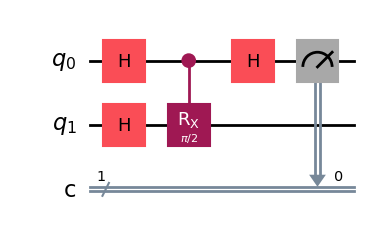

In [10]:
E = 1.0       
T = np.pi / 4  
theta = E * T  

qc = QuantumCircuit(2, 1)

qc.h(1)
qc.h(0)
qc.crx(2*theta, 0, 1)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')


In [11]:
sim = AerSimulator()
result = sim.run(qc, shots=100000).result()
counts = result.get_counts()

print('Measurement counts:', counts)



Measurement counts: {'1': 14593, '0': 85407}


#### Question 2.3

In [12]:
def create_berry_phase_circuit(h_vec_func, T=2*np.pi, Nt=1000):
    
    dt = T / Nt
    qc = QuantumCircuit(2, 1) 

    qc.x(1)
    qc.h(1)
    qc.h(0)
    
    for n in range(Nt):
        lmbd = n / Nt
        h = h_vec_func(lmbd)
        H_n = h[0]*X + h[1]*Y + h[2]*Z
        U_n_matrix = expm(-1j * H_n * dt)
        
        U_gate = UnitaryGate(U_n_matrix, label=f'U_{n}')
        controlled_U_gate = U_gate.control(1)

        qc.append(controlled_U_gate, [0, 1])

    qc.h(0)
    qc.measure(0, 0)

    return qc

In [13]:
def simulate_berry_phase_circuit(h_vec, T=2*np.pi, Nt=1000, shots=100000):
    berry_qc = create_berry_phase_circuit(h_vec, T, Nt)
    berry_qc_decomposed = berry_qc.decompose()

    sim = AerSimulator()
    result = sim.run(berry_qc_decomposed, shots=shots).result()
    counts = result.get_counts()
    
    total_shots = counts.get('0', 0) + counts.get('1', 0)
    p0 = counts.get('0', 0) / total_shots
    theta_total = 2 * np.arccos(np.sqrt(p0))

    final_berry_phase = theta_total % (2 * np.pi)
    print('Measurement counts:', counts)
    print(f'Calculated Berry phase from circuit (mod 2pi) = {final_berry_phase:.3f} rad')

In [14]:
simulate_berry_phase_circuit(h_vec_0, T=2*np.pi)

Measurement counts: {'0': 100000}
Calculated Berry phase from circuit (mod 2pi) = 0.000 rad


In [15]:
simulate_berry_phase_circuit(h_vec_1, T=2*np.pi)

Measurement counts: {'0': 13010, '1': 86990}
Calculated Berry phase from circuit (mod 2pi) = 2.404 rad


In [16]:
simulate_berry_phase_circuit(h_vec_2, T=2*np.pi)

Measurement counts: {'0': 62379, '1': 37621}
Calculated Berry phase from circuit (mod 2pi) = 1.321 rad


In [17]:
simulate_berry_phase_circuit(h_vec_3, T=2*np.pi)

Measurement counts: {'0': 21178, '1': 78822}
Calculated Berry phase from circuit (mod 2pi) = 2.185 rad


## Part 3

#### Question 3.1

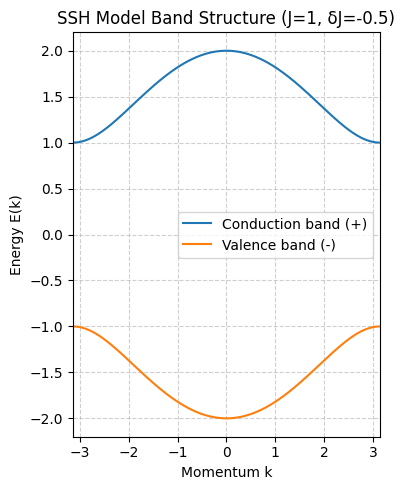

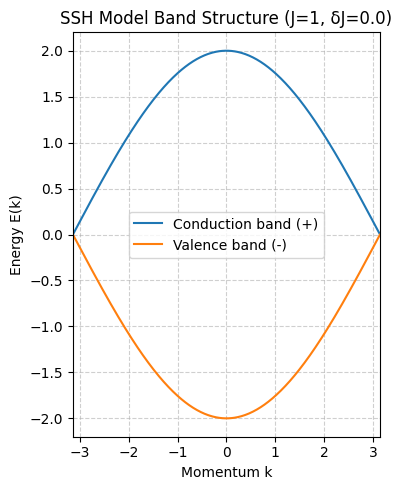

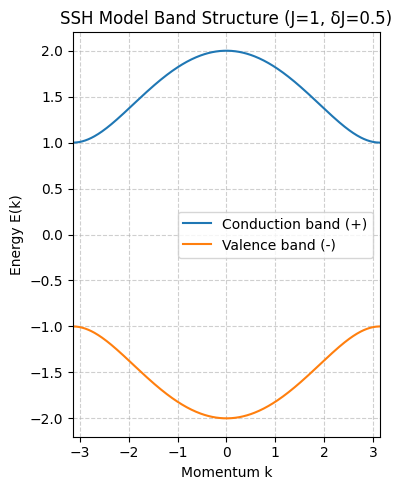

In [18]:
J = 1
deltaJ_values = [-0.5, 0.0, 0.5]
k_vals = np.linspace(-np.pi, np.pi, 400)

for deltaJ in deltaJ_values:

    h_x = -(J + deltaJ) - (J - deltaJ) * np.cos(k_vals)
    h_y = -(J - deltaJ) * np.sin(k_vals)

    E = np.sqrt(h_x**2 + h_y**2)

    plt.figure(figsize=(4, 5))
    plt.plot(k_vals, E, label='Conduction band (+)')
    plt.plot(k_vals, -E, label='Valence band (-)')
    
    plt.title(f'SSH Model Band Structure (J=1, δJ={deltaJ})', fontsize=12)
    plt.xlabel('Momentum k')
    plt.ylabel('Energy E(k)')
    plt.xlim(-np.pi, np.pi)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


#### Question 3.2

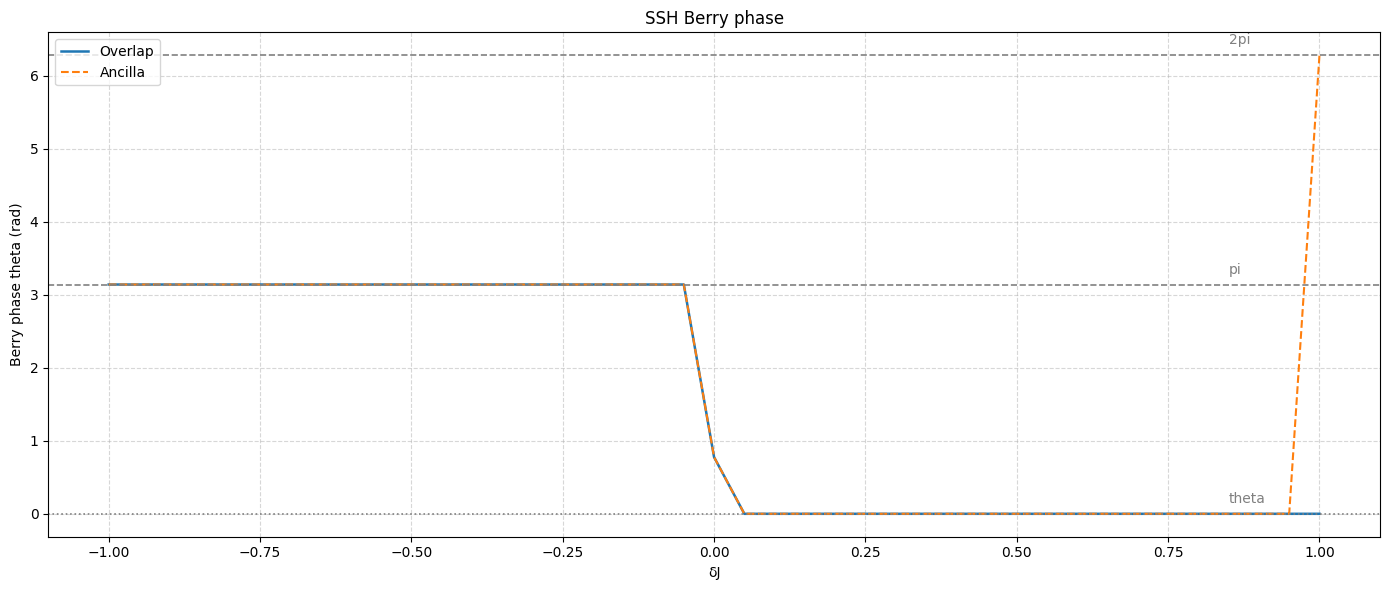

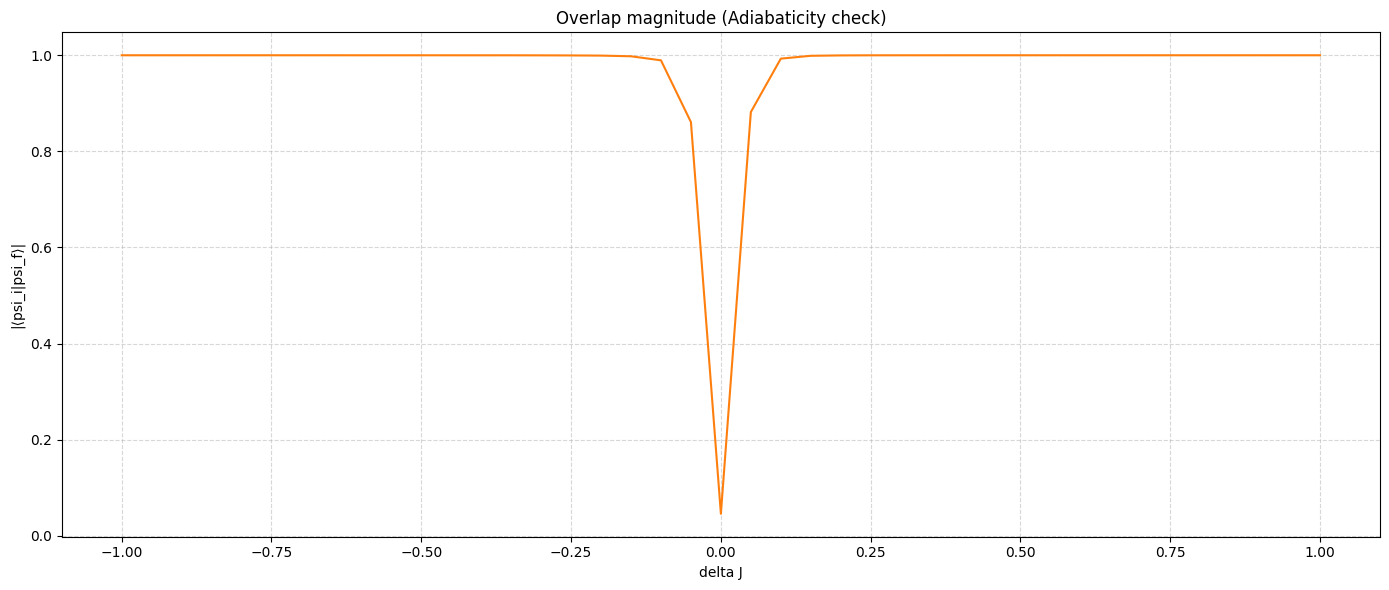

In [19]:

def Hk(k: float, J: float = 1.0, dJ: float = 0.0):
    hx = -(J + dJ) - (J - dJ) * np.cos(k)
    hy = -(J - dJ) * np.sin(k)
    hz = 0.0
    return hx * X + hy * Y + hz * Z

def unitary_from_H(H, dt):
    trH2 = np.trace(H @ H).real
    hnorm = math.sqrt(max(trH2 / 2.0, 0.0))
    if hnorm < 1e-12:
        return np.eye(2, dtype=complex)
    c = math.cos(hnorm * dt)
    s = math.sin(hnorm * dt) / hnorm
    return c * np.eye(2, dtype=complex) - 1j * s * H

def ground_state(H):
    evals, evecs = np.linalg.eigh(H)
    idx = evals.argmin()
    return evecs[:, idx], evals[idx].real

def evolve_path_unitary(k_path, T_half, steps, J, dJ, backward=False):
    dt = T_half / steps
    U = np.eye(2, dtype=complex)
    for k in k_path:
        U_step = unitary_from_H(Hk(k, J, dJ), dt)
        if backward:
            U = U_step.conj().T @ U
        else:
            U = U_step @ U
    return U

def berry_phase_half_time_reversal(J=1.0, dJ=0.0, T=200*np.pi, Nt=2000):
    steps = Nt // 2
    T_half = T / 2
    t1 = np.linspace(0, T_half, steps, endpoint=False)
    k1 = np.linspace(-math.pi, 0, steps + 1)
    k2 = np.linspace(0, math.pi, steps + 1)
    

    psi_i, _ = ground_state(Hk(-math.pi, J, dJ))
    U1 = evolve_path_unitary(k1, T_half, steps, J, dJ)
    U2 = evolve_path_unitary(k2, T_half, steps, J, dJ, backward=True)
    U_total = U2 @ U1
    psi_f = U_total @ psi_i

    O = np.vdot(psi_i, psi_f)
    theta = cmath.phase(O)
    overlap_mag = abs(O)

    P0 = np.array([[1,0],[0,0]], dtype=complex)
    P1 = np.array([[0,0],[0,1]], dtype=complex)
    CU = np.kron(P0, np.eye(2, dtype=complex)) + np.kron(P1, U_total)
    plus = np.array([1,1], dtype=complex) / np.sqrt(2)
    psi0 = np.kron(plus, psi_i)
    psi_after = CU @ psi0

    Hgate = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]], dtype=complex)
    U_measX = np.kron(Hgate, np.eye(2, dtype=complex))
    psi_mx = U_measX @ psi_after
    amp0 = psi_mx[0:2]
    ex = 2*np.vdot(amp0, amp0).real - 1

    Sdg = np.array([[1,0],[0,-1j]], dtype=complex)
    U_measY = np.kron(Hgate @ Sdg, np.eye(2, dtype=complex))
    psi_my = U_measY @ psi_after
    amp0y = psi_my[0:2]
    ey = 2*np.vdot(amp0y, amp0y).real - 1

    theta_qc = math.atan2(ey, ex)

    def wrap(a): return (a + 2*np.pi) % (2*np.pi)
    return wrap(theta), wrap(theta_qc), overlap_mag


def run_sweep_and_plot(J=1.0, dJ_min=-1.0, dJ_max=1.0, num=41, T=200*np.pi, Nt=2000):
    dJs = np.linspace(dJ_min, dJ_max, num)
    thetas, thetas_qc, overlaps = [], [], []

    for dJ in dJs:
        th, th_qc, ov = berry_phase_half_time_reversal(J, dJ, T, Nt)
        thetas.append(th)
        thetas_qc.append(th_qc)
        overlaps.append(ov)

    plt.figure(figsize=(14,6))
    plt.plot(dJs, thetas, label='Overlap', linewidth=1.8)
    plt.plot(dJs, thetas_qc, '--', label='Ancilla', linewidth=1.5)

    plt.axhline(0, color='gray', linestyle=':', linewidth=1.2)
    plt.axhline(2*np.pi, color='gray', linestyle='--', linewidth=1.2)
    plt.axhline(np.pi, color='gray', linestyle='--', linewidth=1.2)
    plt.text(dJ_max*0.85, 0.15, 'theta', color='gray')
    plt.text(dJ_max*0.85, 2*np.pi+0.15, '2pi', color='gray')
    plt.text(dJ_max*0.85, np.pi+0.15, 'pi', color='gray')

    plt.xlabel('δJ')
    plt.ylabel('Berry phase theta (rad)')
    plt.title('SSH Berry phase')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14,6))
    plt.plot(dJs, overlaps, color='tab:orange')
    plt.xlabel('delta J')
    plt.ylabel('|⟨psi_i|psi_f⟩|')
    plt.title('Overlap magnitude (Adiabaticity check)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


run_sweep_and_plot()

#### Question 3.6

In [20]:
# Helper function

def get_pauli_ops(N):
    I = np.eye(2, dtype=complex)
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    
    X_ops, Y_ops, Z_ops = [], [], []
    
    for i in range(N):
        op_x, op_y, op_z = [1], [1], [1]
        for j in range(N):
            if j == i:
                op_x = np.kron(op_x, X)
                op_y = np.kron(op_y, Y)
                op_z = np.kron(op_z, Z)
            else:
                op_x = np.kron(op_x, I)
                op_y = np.kron(op_y, I)
                op_z = np.kron(op_z, I)
        X_ops.append(op_x)
        Y_ops.append(op_y)
        Z_ops.append(op_z)
        
    return X_ops, Y_ops, Z_ops


def get_half_filling_indices(N):
    return [i for i in range(2**N) if bin(i).count('1') == N // 2]


def project_hamiltonian(H, indices):
    return H[np.ix_(indices, indices)]


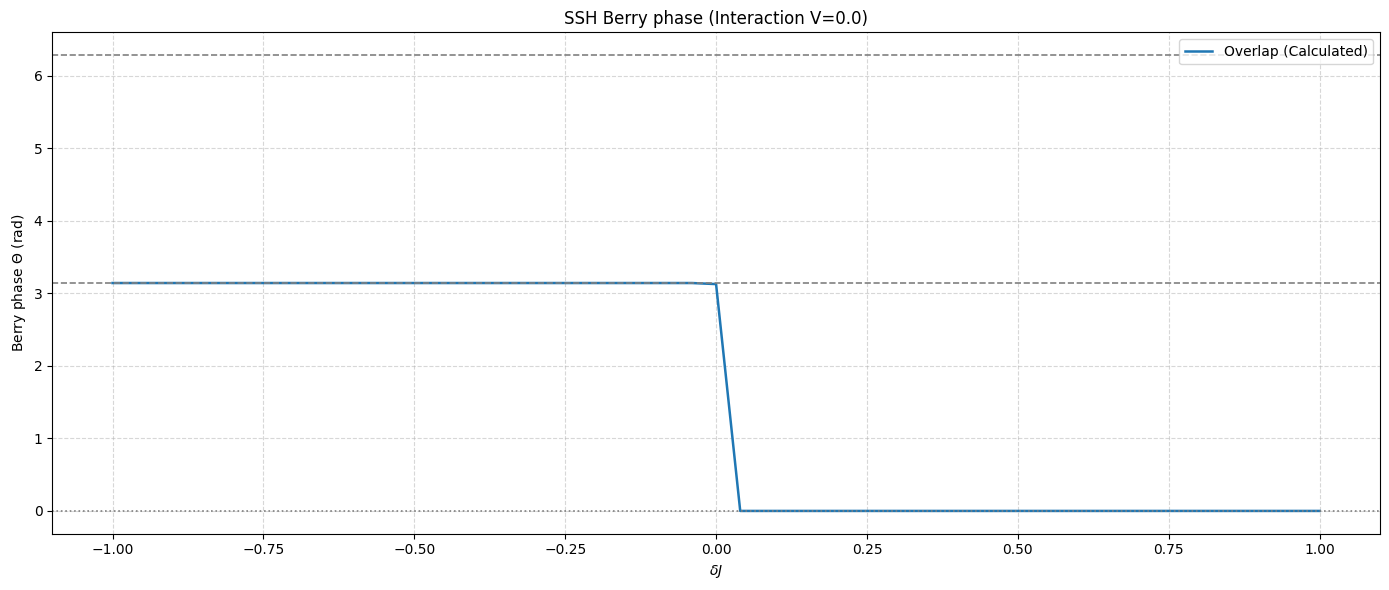

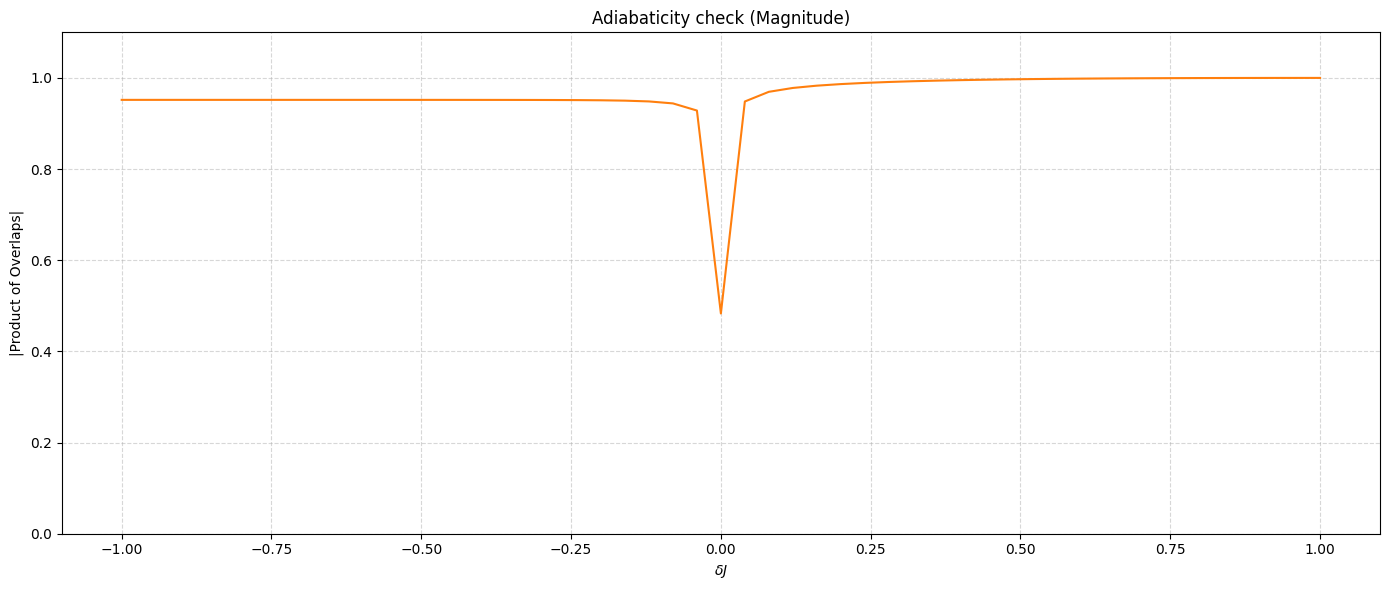

In [ ]:
def H_theta(theta, J, deltaJ, V, N, X, Y, Z):
    H = np.zeros((2**N, 2**N), dtype=complex)

    for j in range(N - 1):
        coeff = -(J + deltaJ) / 2.0 if j % 2 == 0 else -(J - deltaJ) / 2.0
        H += coeff * (X[j+1] @ X[j] + Y[j+1] @ Y[j])

    Z_string = np.eye(2**N, dtype=complex)
    for k in range(0, N - 1):
        Z_string = Z[k] @ Z_string

    coeff_pbc = -(J - deltaJ) / 2.0
    term_cos = np.cos(theta) * (X[0] @ X[N-1] + Y[0] @ Y[N-1])
    term_sin = np.sin(theta) * (X[0] @ Y[N-1] - Y[0] @ X[N-1])

    H += coeff_pbc * (Z_string @ (term_cos + term_sin))

    for j in range(N):
        j_next = (j + 1) % N
        term = np.eye(2**N) - Z[j] - Z[j_next] + Z[j] @ Z[j_next]
        H += (V / 4.0) * term
        
    return H


def berry_phase_twist_simulation(J=1.0, dJ=0.0, V=0.0, N=8, steps=41):
    X, Y, Z = get_pauli_ops(N)
    basis_idx = get_half_filling_indices(N)
    
    thetas = np.linspace(0, 2*np.pi, steps, endpoint=False)
    ground_states = []

    for th in thetas:
        H_full = H_theta(th, J, dJ, V, N, X, Y, Z)
        H_sub = project_hamiltonian(H_full, basis_idx)
        
        vals, vecs = eigh(H_sub)
        ground_states.append(vecs[:, 0])

    overlap_prod = 1.0 + 0.0j
    for i in range(steps):
        psi_curr = ground_states[i]
        psi_next = ground_states[(i + 1) % steps]
        overlap_prod *= np.vdot(psi_curr, psi_next)

    theta_berry = -np.angle(overlap_prod) 
    if theta_berry < -0.001:
        theta_berry += 2*np.pi

    overlap_mag = np.abs(overlap_prod)
    
    return theta_berry, theta_berry, overlap_mag



def run_sweep_and_plot(J=1.0, V=0.0, dJ_min=-1.0, dJ_max=1.0, num=51):

    N_sites = 8
    n_steps = 100
    
    dJs = np.linspace(dJ_min, dJ_max, num)
    thetas, thetas_qc, overlaps = [], [], []

    
    for dJ in dJs:
        th, th_qc, ov = berry_phase_twist_simulation(J, dJ, V, N_sites, n_steps)
        thetas.append(th)
        thetas_qc.append(th_qc)
        overlaps.append(ov)


    plt.figure(figsize=(14, 6))
    plt.plot(dJs, thetas, '-', label='Overlap (Calculated)', linewidth=1.8)
    
    plt.axhline(0, color='gray', linestyle=':', linewidth=1.2)
    plt.axhline(2 * np.pi, color='gray', linestyle='--', linewidth=1.2)
    plt.axhline(np.pi, color='gray', linestyle='--', linewidth=1.2)

    plt.xlabel('$\delta J$')
    plt.ylabel('Berry phase $\Theta$ (rad)')
    plt.title(f'SSH Berry phase (Interaction V={V})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.plot(dJs, overlaps, '-', color='tab:orange')
    plt.xlabel('$\delta J$')
    plt.ylabel('|Product of Overlaps|')
    plt.title('Adiabaticity check (Magnitude)')
    plt.ylim(0.0, 1.1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



run_sweep_and_plot()

#### Question 3.7

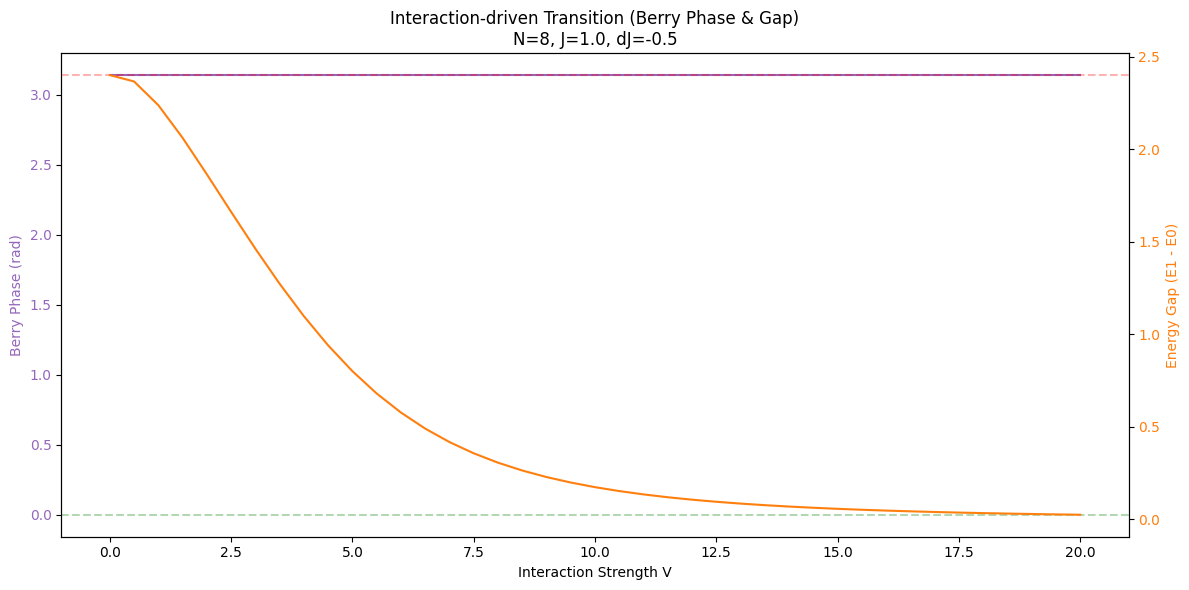

In [22]:


def build_ssh_hamiltonian(theta, J, deltaJ, V, N, X, Y, Z):
    H = np.zeros((2**N, 2**N), dtype=complex)

    for j in range(N - 1):
        coeff = -(J + deltaJ)/2.0 if j % 2 == 0 else -(J - deltaJ)/2.0
        H += coeff * (X[j+1] @ X[j] + Y[j+1] @ Y[j])

    Z_string = np.eye(2**N, dtype=complex)
    for k in range(N - 1): 
        Z_string = Z[k] @ Z_string

    dim = 2**N
    
    Z_string = np.eye(dim, dtype=complex)
    for k in range(N - 1):
        Z_string = Z[k] @ Z_string


    boundary_term = (
        X[N-1] @ Z_string @ X[0] +
        Y[N-1] @ Z_string @ Y[0]
    )
    coeff_pbc = -(J - deltaJ) / 2.0
    term_cos = np.cos(theta) * (X[0] @ X[N-1] + Y[0] @ Y[N-1])
    term_sin = np.sin(theta) * (X[0] @ Y[N-1] - Y[0] @ X[N-1])

    H += coeff_pbc * (Z_string @ (term_cos + term_sin))


    for j in range(N):
        j_next = (j + 1) % N
        term = np.eye(2**N) - Z[j] - Z[j_next] + Z[j] @ Z[j_next]
        H += (V / 4.0) * term

    return H





def analyze_ssh_phase(J, deltaJ, V, N, steps=100):
    X, Y, Z = get_pauli_ops(N)
    basis_idx = get_half_filling_indices(N)
    
    H0 = build_ssh_hamiltonian(0, J, deltaJ, V, N, X, Y, Z)
    H0_sub = project_hamiltonian(H0, basis_idx)
    vals, _ = eigh(H0_sub) 
    gap = vals[1] - vals[0] 

    thetas = np.linspace(0, 2*np.pi, steps, endpoint=False)
    ground_states = []
    for th in thetas:
        H = build_ssh_hamiltonian(th, J, deltaJ, V, N, X, Y, Z)
        H_sub = project_hamiltonian(H, basis_idx)
        _, vecs = eigh(H_sub)
        ground_states.append(vecs[:, 0])
        
    overlap_prod = 1.0 + 0.0j
    for i in range(steps):
        overlap_prod *= np.vdot(ground_states[i], ground_states[(i + 1) % steps])
        
    berry_phase = np.angle(overlap_prod)
    if berry_phase < -0.001: berry_phase += 2*np.pi
    
    return berry_phase, gap


def run_full_analysis():
    N = 8
    J = 1.0
    deltaJ = -0.5
    V_list = np.linspace(0, 20, 41)
    
    phases = []
    gaps = []
    
    for V in V_list:
        bp, gap = analyze_ssh_phase(J, deltaJ, V, N)
        phases.append(bp)
        gaps.append(gap)
        

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:purple'
    ax1.set_xlabel('Interaction Strength V')
    ax1.set_ylabel('Berry Phase (rad)', color=color)
    ax1.plot(V_list, phases, '-', color=color, label='Berry Phase')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(np.pi, color='r', linestyle='--', alpha=0.3, label='Topological')
    ax1.axhline(0, color='g', linestyle='--', alpha=0.3, label='Trivial')

    ax2 = ax1.twinx()  
    color = 'tab:orange'
    ax2.set_ylabel('Energy Gap (E1 - E0)', color=color)
    ax2.plot(V_list, gaps, '-', color=color, label='Energy Gap')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Interaction-driven Transition (Berry Phase & Gap)\nN={N}, J={J}, dJ={deltaJ}')
    fig.tight_layout()
    plt.show()


run_full_analysis()

#### Question 3.8

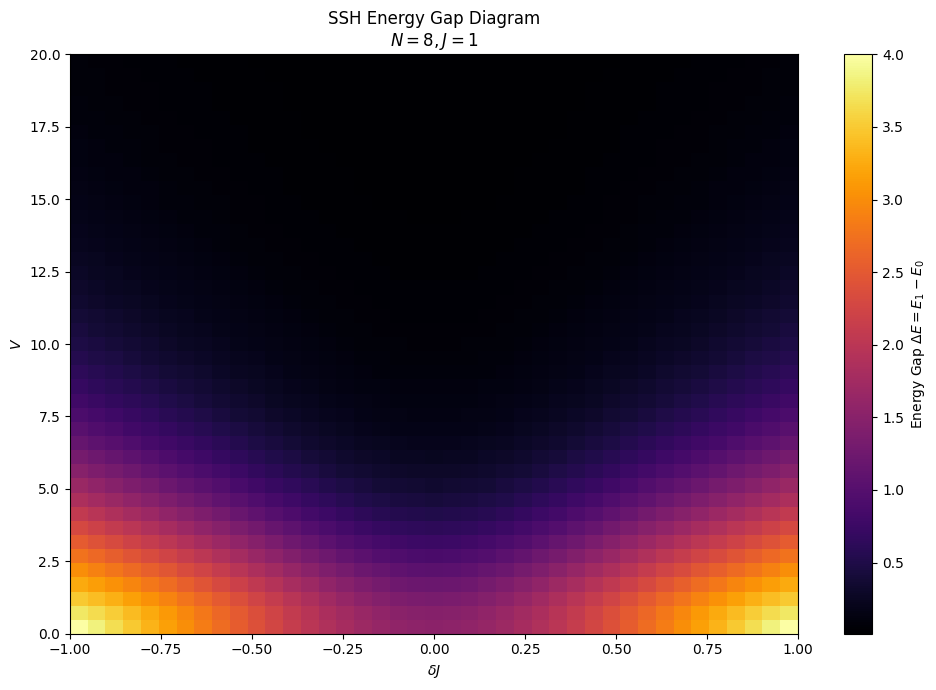

In [23]:
def build_ssh_hamiltonian(J, deltaJ, V, N, X, Y, Z):

    dim = 2**N
    H = np.zeros((dim, dim), dtype=complex)

    for j in range(N - 1):
        if j % 2 == 0:
            t = J + deltaJ
        else:
            t = J - deltaJ

        coeff = -(t) / 2.0
        H += coeff * (X[j+1] @ X[j] + Y[j+1] @ Y[j])

    coeff_pbc = -(J - deltaJ) / 2.0

    Z_string = np.eye(dim, dtype=complex)
    for k in range(N - 1):
        Z_string = Z[k] @ Z_string


    boundary_term = (
        X[N-1] @ Z_string @ X[0] +
        Y[N-1] @ Z_string @ Y[0]
    )

    H += coeff_pbc * boundary_term

    for j in range(N):
        j_next = (j + 1) % N
        term = (
            np.eye(dim, dtype=complex)
            - Z[j]
            - Z[j_next]
            + Z[j] @ Z[j_next]
        )
        H += (V / 4.0) * term

    return H


def compute_gap(J, deltaJ, V, N, X, Y, Z, basis_idx):
    H = build_ssh_hamiltonian(J, deltaJ, V, N, X, Y, Z)
    H_sub = project_hamiltonian(H, basis_idx)

    vals = np.linalg.eigvalsh(H_sub)
    vals = np.sort(vals)
    return vals[1] - vals[0]


def plot_phase_diagram():
    N = 8
    J = 1.0

    dJ_res = 41
    V_res = 41

    dJs = np.linspace(-1.0, 1.0, dJ_res)
    Vs = np.linspace(0.0, 20.0, V_res)

    gaps = np.zeros((V_res, dJ_res))

    X, Y, Z = get_pauli_ops(N)
    basis_idx = get_half_filling_indices(N)


    for i, Vval in enumerate(Vs):
        for j, dJval in enumerate(dJs):
            gaps[i, j] = compute_gap(J, dJval, Vval, N, X, Y, Z, basis_idx)

    plt.figure(figsize=(10, 7))
    extent = [dJs.min(), dJs.max(), Vs.min(), Vs.max()]

    plt.imshow(gaps, origin='lower', extent=extent, aspect='auto', cmap='inferno')
    plt.colorbar(label=r'Energy Gap $\Delta E = E_1 - E_0$')

    plt.xlabel(r'$\delta J$')
    plt.ylabel(r'$V$')
    plt.title('SSH Energy Gap Diagram\n$N=8, J=1$')

    plt.tight_layout()
    plt.show()


plot_phase_diagram()
